In [1]:
# New Jupyter cell (index 0): load all instance files under the EVRP+ABC dataset
# - Recursively reads text files under Type_x and Type_y (and their Customer_* subfolders)
# - Returns a single combined pandas DataFrame and a dict of individual file DataFrames
# - Adjust base_dir if needed

import os
from pathlib import Path
import pandas as pd

try:
    from tqdm import tqdm
    _tqdm = True
except Exception:
    _tqdm = False

BASE_DIR = Path(r"C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC")

def _read_instance_file(path: Path) -> pd.DataFrame:
    """
    Read one instance text file into a pandas DataFrame.
    Assumes the file has a header line with column names and rows separated by whitespace.
    Falls back to a robust regex separator.
    """
    # try a robust whitespace separator (handles multiple spaces/tabs)
    try:
        df = pd.read_csv(path, sep=r'\s+', engine='python', comment='#', header=0, skip_blank_lines=True)
    except Exception:
        # last resort: read manually and parse lines
        with path.open('r', encoding='utf-8', errors='replace') as f:
            lines = [ln.strip() for ln in f if ln.strip()]
        if not lines:
            return pd.DataFrame()
        header = lines[0].split()
        data = [ln.split() for ln in lines[1:]]
        df = pd.DataFrame(data, columns=header)
    # try to convert numeric columns where possible
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')
    return df

def load_all_instances(base_dir: Path = BASE_DIR):
    """
    Walks base_dir, reads instance files (txt/csv/dat), and returns:
      - combined_df: single DataFrame with an extra metadata columns:
            'instance_type' (Type_x / Type_y),
            'customer_group' (e.g., Customer_50),
            'source_file' (file name)
      - file_dfs: dict[path -> DataFrame] for each file
    """
    base_dir = Path(base_dir)
    allowed_suffixes = {'.txt', '.csv', '.dat'}
    file_paths = [p for p in base_dir.rglob('*') if p.is_file() and p.suffix.lower() in allowed_suffixes]

    file_dfs = {}
    rows = []
    iterator = tqdm(file_paths, desc="Reading files") if _tqdm else file_paths
    for p in iterator:
        try:
            df = _read_instance_file(p)
            if df.empty:
                continue
            # metadata
            # assume path like .../<Type_x or Type_y>/<Customer_50>/file.txt
            parts = p.relative_to(base_dir).parts
            instance_type = parts[0] if len(parts) >= 3 else (parts[0] if parts else "")
            customer_group = parts[1] if len(parts) >= 2 else ""
            # attach metadata to each row
            df = df.copy()
            df['instance_type'] = instance_type
            df['customer_group'] = customer_group
            df['source_file'] = p.name
            df['source_path'] = str(p)
            file_dfs[str(p)] = df
            rows.append(df)
        except Exception as e:
            # skip problematic files but report
            print(f"Skipped {p} due to error: {e}")

    if rows:
        combined_df = pd.concat(rows, ignore_index=True, sort=False)
    else:
        combined_df = pd.DataFrame()

    # optionally convert common numeric columns to numeric (if parsed as strings)
    numeric_cols = ['x', 'y', 'demand', 'DeliveryDemand', 'PickupDemand',
                    'DivisionRate', 'ReadyTime', 'DueDate', 'ServiceTime']
    for col in numeric_cols:
        if col in combined_df.columns:
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

    print(f"Loaded {len(file_dfs)} files, total rows: {len(combined_df)}")
    return combined_df, file_dfs

# Example usage:
# combined_df, file_dfs = load_all_instances(BASE_DIR)
# combined_df.head()

### lets see data

In [3]:
combined_df, file_dfs = load_all_instances(BASE_DIR)

Reading files:   0%|          | 0/3000 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_1792\2930269647.py:38: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
Reading files:   0%|          | 1/3000 [00:00<07:00,  7.13it/s]C:\Users\User\AppData\Local\Temp\ipykernel_1792\2930269647.py:38: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
C:\Users\User\AppData\Local\Temp\ipykernel_1792\2930269647.py:38: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
C:\Users\User\AppData\Local\Temp\ipykernel_17

Loaded 3000 files, total rows: 180072


In [4]:
combined_df.head()

,StringID,Type,x,y,demand,DeliveryDemand,PickupDemand,DivisionRate,ReadyTime,DueDate,ServiceTime,instance_type,customer_group,source_file,source_path
0,D0,d,50.0,150.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...
1,S0,s,50.0,75.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...
2,F0,f,50.0,75.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...
3,F1,f,77.0,52.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...
4,F2,f,57.0,82.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...


Rows, columns: (180072, 15)

Columns and dtypes:
StringID           object
Type               object
x                 float64
y                 float64
demand            float64
DeliveryDemand    float64
PickupDemand      float64
DivisionRate      float64
ReadyTime         float64
DueDate           float64
ServiceTime       float64
instance_type      object
customer_group     object
source_file        object
source_path        object
dtype: object

Head:
StringID Type    x     y  demand  DeliveryDemand  PickupDemand  DivisionRate  ReadyTime  DueDate  ServiceTime                        instance_type customer_group   source_file                                                                                                         source_path
      D0    d 50.0 150.0     0.0             0.0           0.0           0.0        0.0   9999.0          0.0 manilakbay-2E-EVRP-Instances-dc2c2d0         Type_x C101_C10x.txt C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\manilakbay-2E-EVRP-Instanc

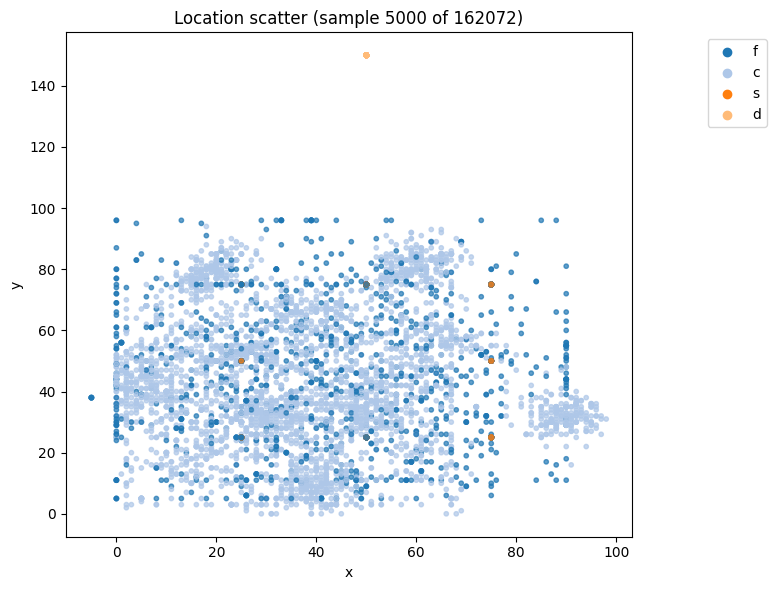

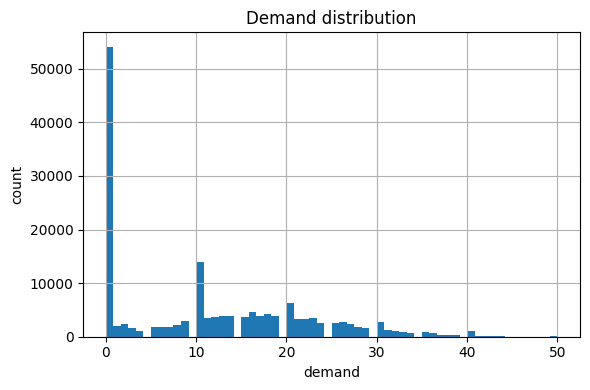

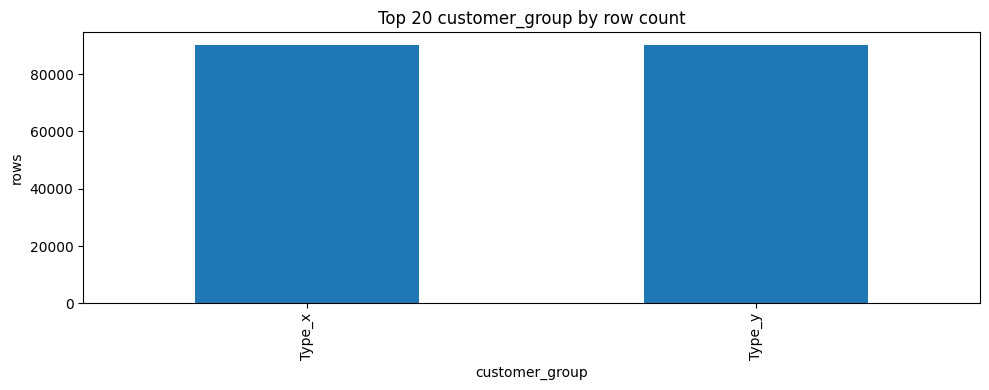

In [5]:
import numpy as np

# Quick EDA & visualization of combined_df (uses existing combined_df variable)

# Basic summaries
print("Rows, columns:", combined_df.shape)
print("\nColumns and dtypes:")
print(combined_df.dtypes)
print("\nHead:")
print(combined_df.head().to_string(index=False))

print("\ninstance_type value counts:")
print(combined_df['instance_type'].value_counts().head(20))

print("\nType value counts (top 20):")
print(combined_df['Type'].value_counts().head(20))

# Plots (sample coordinates for performance)
import matplotlib.pyplot as plt

# Scatter of coordinates (filter rows with x,y)
coords = combined_df[['x', 'y', 'Type']].dropna(subset=['x', 'y'])
n_coords = len(coords)
sample_n = min(5000, n_coords)
coords_s = coords.sample(sample_n, random_state=1) if n_coords > sample_n else coords

# Map types to colors
types = list(coords_s['Type'].unique())
cmap = plt.get_cmap('tab20')
color_map = {t: cmap(i % 20) for i, t in enumerate(types)}
colors = coords_s['Type'].map(color_map)

plt.figure(figsize=(8,6))
plt.scatter(coords_s['x'], coords_s['y'], s=10, c=list(colors), alpha=0.7)
plt.xlabel('x'); plt.ylabel('y')
plt.title(f'Location scatter (sample {len(coords_s)} of {n_coords})')
# legend
for t, c in color_map.items():
    plt.scatter([], [], c=[c], label=str(t))
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), ncol=1)
plt.tight_layout()
plt.show()

# Demand distribution
plt.figure(figsize=(6,4))
combined_df['demand'].dropna().hist(bins=60)
plt.title('Demand distribution')
plt.xlabel('demand'); plt.ylabel('count')
plt.tight_layout()
plt.show()

# Top customer_groups by rows
top_customers = combined_df['customer_group'].value_counts().head(20)
plt.figure(figsize=(10,4))
top_customers.plot(kind='bar')
plt.title('Top 20 customer_group by row count')
plt.ylabel('rows')
plt.tight_layout()
plt.show()

In [8]:
# create a 2k subset of the loaded dataset for use in subsequent cells
df_2k = combined_df.head(2000).reset_index(drop=True)
combined_df_2000 = df_2k  # alias if you prefer this name elsewhere

# quick check
print("df_2k shape:", df_2k.shape)
df_2k.head()

df_2k shape: (2000, 15)


,StringID,Type,x,y,demand,DeliveryDemand,PickupDemand,DivisionRate,ReadyTime,DueDate,ServiceTime,instance_type,customer_group,source_file,source_path
0,D0,d,50.0,150.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...
1,S0,s,50.0,75.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...
2,F0,f,50.0,75.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...
3,F1,f,77.0,52.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...
4,F2,f,57.0,82.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,manilakbay-2E-EVRP-Instances-dc2c2d0,Type_x,C101_C10x.txt,C:\Users\User\Downloads\EVRP+ABC (1)\EVRP+ABC\...


## Rayen Ameur NN

In [9]:
import numpy as np

def nearest_neighbor_vrp(df, depot_type='d', customer_type='c', capacity=100, autonomy=150):
    depot = df[df['Type'] == depot_type].iloc[0]
    customers = df[df['Type'] == customer_type].copy()
    stations = df[df['Type'] == 'f'].copy()

    unvisited = set(customers.index)
    routes = []
    total_cost = 0

    while unvisited:
        route = [depot.name]
        load = 0
        battery = autonomy
        current = depot
        cost = 0

        while unvisited:
            dists = customers.loc[list(unvisited)][['x', 'y']].apply(
                lambda row: np.hypot(row['x'] - current['x'], row['y'] - current['y']), axis=1)
            feasible = [i for i in dists.index if load + customers.loc[i, 'demand'] <= capacity]
            if not feasible:
                break
            next_idx = dists[feasible].idxmin()
            next_customer = customers.loc[next_idx]
            dist = dists[next_idx]

            if battery < dist:
                if not stations.empty:
                    station_dists = stations[['x', 'y']].apply(
                        lambda row: np.hypot(row['x'] - current['x'], row['y'] - current['y']), axis=1)
                    station_idx = station_dists.idxmin()
                    station = stations.loc[station_idx]
                    route.append(station.name)
                    cost += station_dists[station_idx]
                    battery = autonomy
                    current = station
                    continue
                else:
                    break
            route.append(next_idx)
            cost += dist
            battery -= dist
            load += next_customer['demand']
            current = next_customer
            unvisited.remove(next_idx)

        dist_to_depot = np.hypot(depot['x'] - current['x'], depot['y'] - current['y'])
        if battery < dist_to_depot and not stations.empty:
            station_dists = stations[['x', 'y']].apply(
                lambda row: np.hypot(row['x'] - current['x'], row['y'] - current['y']), axis=1)
            station_idx = station_dists.idxmin()
            station = stations.loc[station_idx]
            route.append(station.name)
            cost += station_dists[station_idx]
            battery = autonomy
            current = station
            dist_to_depot = np.hypot(depot['x'] - current['x'], depot['y'] - current['y'])
        route.append(depot.name)
        cost += dist_to_depot
        total_cost += cost
        routes.append({'route': route, 'cost': cost})

    return routes, total_cost

# Use the smaller df_2k for quick testing (filter by existing customer_group `cg`)
df_subset = df_2k[df_2k['customer_group'] == cg]

nn_routes, nn_total_cost = nearest_neighbor_vrp(df_subset)

nn_results = {
    'routes': nn_routes,
    'total_cost': nn_total_cost,
    'customer_group': cg
}

print(f"Total cost (NN): {nn_total_cost}")
print(f"Nombre de tournées: {len(nn_routes)}")


Total cost (NN): 37955.60385108059
Nombre de tournées: 177


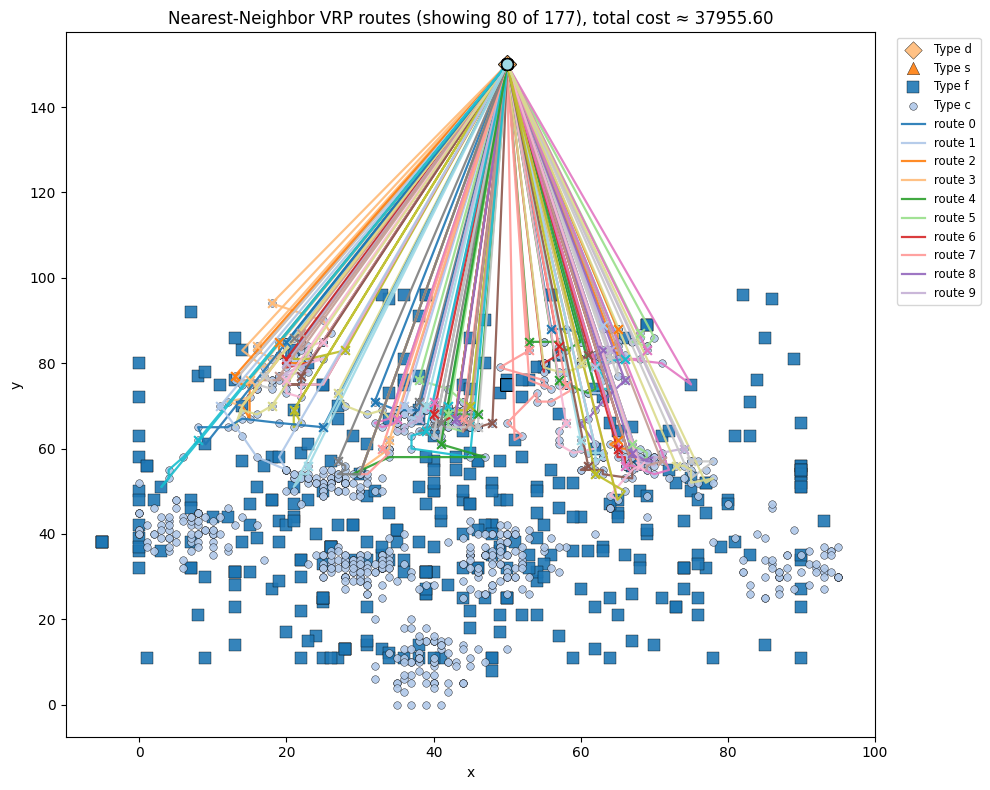

In [10]:
# Visualize NN routes from nn_routes on df_subset
# Uses existing variables: df_subset, nn_routes, nn_total_cost, color_map, cmap, plt, np

# configure: how many routes to draw (set to None to draw all)
max_routes = 80
routes_to_plot = nn_routes if max_routes is None else nn_routes[:max_routes]

plt.figure(figsize=(10, 8))

# Plot background points by Type using existing color_map
types_present = df_subset['Type'].unique()
markers = {'d': 'D', 'f': 's', 's': '^', 'c': 'o'}  # depot, station, special, customer
for t in types_present:
    sub = df_subset[df_subset['Type'] == t].dropna(subset=['x', 'y'])
    if sub.empty:
        continue
    col = color_map.get(t, (0.5, 0.5, 0.5, 0.9))
    m = markers.get(t, 'o')
    plt.scatter(sub['x'], sub['y'], c=[col], label=f"Type {t}", s=30 if t == 'c' else 80, marker=m, edgecolor='k', linewidth=0.3, alpha=0.9)

# Prepare a colormap for routes
n_routes = len(routes_to_plot)
route_cmap = plt.get_cmap('tab20')
route_colors = [route_cmap(i % 20) for i in range(n_routes)]

# Helper to get coordinates for an index (robust to missing indices)
def _coord_for(idx):
    try:
        row = df_subset.loc[idx]
    except Exception:
        try:
            row = combined_df.loc[idx]
        except Exception:
            return None, None
    return float(row['x']), float(row['y'])

# Draw each route as a line connecting the nodes in order
for i, r in enumerate(routes_to_plot):
    route_idxs = r['route']
    xs, ys = [], []
    for node in route_idxs:
        x, y = _coord_for(node)
        if np.isnan(x) or np.isnan(y):
            # skip nodes without coordinates
            continue
        xs.append(x); ys.append(y)
    if len(xs) < 2:
        continue
    plt.plot(xs, ys, color=route_colors[i], linewidth=1.6, alpha=0.9, label=f"route {i}" if i < 10 else None)
    # mark route start (depot) and first customer for readability
    plt.scatter(xs[0], ys[0], c=[route_colors[i]], edgecolor='k', s=70, zorder=5)
    plt.scatter(xs[1], ys[1], c=[route_colors[i]], marker='x', s=40, zorder=5)

plt.title(f"Nearest-Neighbor VRP routes (showing {len(routes_to_plot)} of {len(nn_routes)}), total cost ≈ {nn_total_cost:.2f}")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.show()

 ### Clarke & Wright Rami ben atig

Clarke & Wright: 179 routes, total cost ≈ 37389.34 (capacity=100)


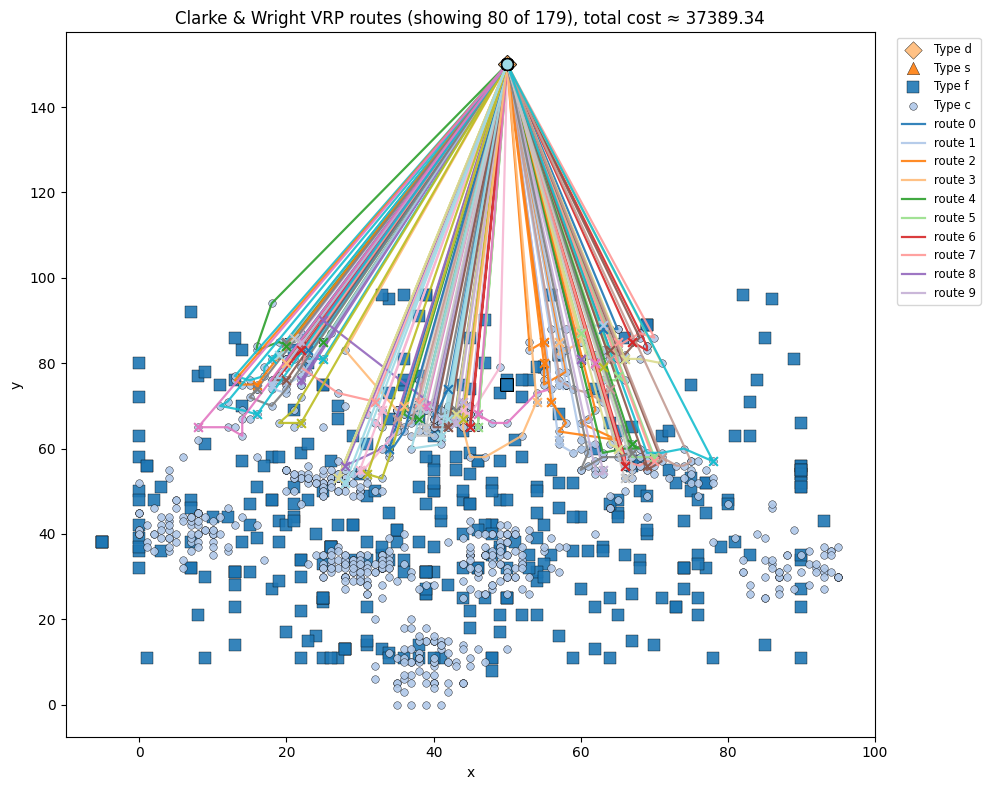

Route 0: customers=[827, 279, 420, 828], load=78.0, cost=129.14
Route 1: customers=[534, 1448, 1908], load=79.0, cost=131.76
Route 2: customers=[12, 170, 859, 1609], load=93.0, cost=135.09
Route 3: customers=[1995, 1924, 488, 760, 148, 1463], load=99.0, cost=138.38
Route 4: customers=[1325, 96, 1303, 1564], load=78.0, cost=139.29
Route 5: customers=[1348, 580, 399, 1992, 873], load=97.0, cost=139.55
Route 6: customers=[126, 537, 482, 418, 1837], load=92.0, cost=139.70
Route 7: customers=[168, 1651, 1380, 1677], load=90.0, cost=141.24
Route 8: customers=[1423, 207, 253, 1840, 78, 16, 59, 169], load=100.0, cost=141.43
Route 9: customers=[1217, 32, 162, 1836, 1648], load=71.0, cost=141.72


In [11]:
# Clarke & Wright (Savings) heuristic for CVRP + visualization
# Uses existing variables if present: df_subset, df_2k, combined_df_2000, plt, np
# Does not re-import modules.

def clarke_wright(df, depot_type='d', customer_type='c', capacity=100):
    # choose depot and customers
    depots = df[df['Type'] == depot_type].dropna(subset=['x', 'y'])
    if depots.empty:
        raise ValueError("No depot found in dataframe with Type == '{}'".format(depot_type))
    depot = depots.iloc[0]
    customers = df[df['Type'] == customer_type].dropna(subset=['x', 'y']).copy()
    if customers.empty:
        return [], 0.0, depot, customers

    # prepare demands and indices
    cust_idx = list(customers.index)
    demand = customers['demand'].fillna(0).to_dict()

    # distance function
    def dist(i, j):
        xi, yi = (depot['x'], depot['y']) if i == '__DEPOT__' else (float(df.loc[i, 'x']), float(df.loc[i, 'y']))
        xj, yj = (depot['x'], depot['y']) if j == '__DEPOT__' else (float(df.loc[j, 'x']), float(df.loc[j, 'y']))
        return float(np.hypot(xi - xj, yi - yj))

    # initial routes: one customer per route (route stores customer indices only)
    routes = {i: [i] for i in cust_idx}
    loads = {i: demand.get(i, 0.0) for i in cust_idx}
    route_of = {i: i for i in cust_idx}

    # compute savings for all customer pairs
    savings = []
    depot_id = '__DEPOT__'
    for i_idx in range(len(cust_idx)):
        for j_idx in range(i_idx + 1, len(cust_idx)):
            i = cust_idx[i_idx]; j = cust_idx[j_idx]
            s = dist(depot_id, i) + dist(depot_id, j) - dist(i, j)
            savings.append((s, i, j))
    savings.sort(reverse=True, key=lambda x: x[0])

    # merge routes according to savings
    for s, i, j in savings:
        ri = route_of[i]; rj = route_of[j]
        if ri == rj:
            continue
        route_i = routes[ri]; route_j = routes[rj]

        # check if i is at an end of route_i and j at an end of route_j such that they can be concatenated
        can_connect = False
        # prefer orientation: route_i end == i and route_j start == j => route_i + route_j
        if route_i[-1] == i and route_j[0] == j:
            new_route = route_i + route_j
            can_connect = True
        # route_j end == j and route_i start == i => route_j + route_i
        elif route_j[-1] == j and route_i[0] == i:
            new_route = route_j + route_i
            can_connect = True
        # other orientations would require reversing a route (we skip reversing for simplicity)
        else:
            can_connect = False

        if not can_connect:
            continue

        # capacity check
        new_load = sum(demand.get(n, 0.0) for n in new_route)
        if new_load > capacity:
            continue

        # perform merge: assign to smaller key
        new_key = ri
        old_key = rj
        if new_key == old_key:
            continue
        # update routes and route_of mappings
        routes[new_key] = new_route
        loads[new_key] = new_load
        for node in new_route:
            route_of[node] = new_key
        # remove old route
        if old_key in routes:
            del routes[old_key]
            if old_key in loads:
                del loads[old_key]

    # build final routes with depot endpoints and compute costs
    final_routes = []
    total_cost = 0.0
    for rnodes in routes.values():
        # construct full route [depot, ...customers..., depot]
        full = [depot_id] + rnodes + [depot_id]
        # compute cost
        cost = 0.0
        for a, b in zip(full[:-1], full[1:]):
            cost += dist(a, b)
        final_routes.append({'route': full, 'cost': cost, 'load': sum(demand.get(n, 0.0) for n in rnodes)})
        total_cost += cost

    # sort by cost descending (optional)
    final_routes.sort(key=lambda r: r['cost'], reverse=False)
    return final_routes, total_cost, depot, customers

# Choose data source: prefer df_subset, else df_2k, else combined_df_2000
_data = None
if 'df_subset' in globals() and isinstance(df_subset, type(df_2k)) and not df_subset.empty:
    _data = df_subset
elif 'df_2k' in globals() and not df_2k.empty:
    _data = df_2k
elif 'combined_df_2000' in globals() and not combined_df_2000.empty:
    _data = combined_df_2000
else:
    raise RuntimeError("No suitable dataframe found (df_subset / df_2k / combined_df_2000)")

# apply Clarke & Wright
cw_capacity = 100  # adjust if you want
cw_routes, cw_total_cost, cw_depot, cw_customers = clarke_wright(_data, capacity=cw_capacity)

print(f"Clarke & Wright: {len(cw_routes)} routes, total cost ≈ {cw_total_cost:.2f} (capacity={cw_capacity})")

# Visualization (similar style to prior plotting cell)
max_routes = 80
routes_to_plot = cw_routes if max_routes is None else cw_routes[:max_routes]

plt.figure(figsize=(10, 8))

# Plot background points by Type
types_present = _data['Type'].unique()
markers = {'d': 'D', 'f': 's', 's': '^', 'c': 'o'}
for t in types_present:
    sub = _data[_data['Type'] == t].dropna(subset=['x', 'y'])
    if sub.empty:
        continue
    col = color_map.get(t, (0.5, 0.5, 0.5, 0.9)) if 'color_map' in globals() else (0.5, 0.5, 0.5, 0.9)
    m = markers.get(t, 'o')
    plt.scatter(sub['x'], sub['y'], c=[col], label=f"Type {t}", s=30 if t == 'c' else 80, marker=m, edgecolor='k', linewidth=0.3, alpha=0.9)

# colors for routes
route_cmap = plt.get_cmap('tab20')
route_colors = [route_cmap(i % 20) for i in range(len(routes_to_plot))]

# helper to get coordinates (handles depot placeholder)
def _coord(idx):
    if idx == '__DEPOT__':
        return float(cw_depot['x']), float(cw_depot['y'])
    r = _data.loc[idx]
    return float(r['x']), float(r['y'])

for i, r in enumerate(routes_to_plot):
    nodes = r['route']
    xs, ys = [], []
    for n in nodes:
        try:
            x, y = _coord(n)
        except Exception:
            x, y = None, None
        if x is None or y is None or np.isnan(x) or np.isnan(y):
            continue
        xs.append(x); ys.append(y)
    if len(xs) < 2:
        continue
    plt.plot(xs, ys, color=route_colors[i], linewidth=1.6, alpha=0.9, label=f"route {i}" if i < 10 else None)
    plt.scatter(xs[0], ys[0], c=[route_colors[i]], edgecolor='k', s=70, zorder=5)  # depot
    if len(xs) > 1:
        plt.scatter(xs[1], ys[1], c=[route_colors[i]], marker='x', s=40, zorder=5)  # first customer

plt.title(f"Clarke & Wright VRP routes (showing {len(routes_to_plot)} of {len(cw_routes)}), total cost ≈ {cw_total_cost:.2f}")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.show()

# Show a compact textual summary of the first few routes
for i, r in enumerate(cw_routes[:10]):
    print(f"Route {i}: customers={r['route'][1:-1]}, load={r['load']:.1f}, cost={r['cost']:.2f}")

##  Route-level Simulated Annealing aziz sfar

SA done: initial cost ≈ 37389.34 (best found ≈ 37389.34), routes=179, iterations=20100


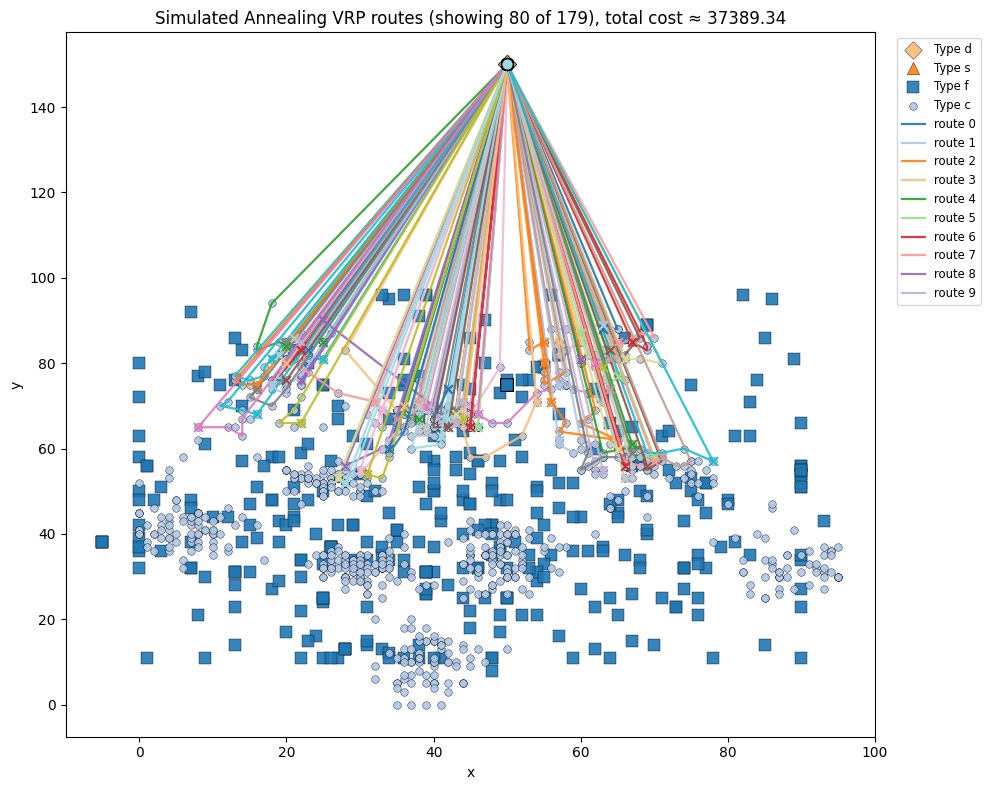

Route 0: customers=[827, 279, 420, 828], load=78.0, cost=129.14
Route 1: customers=[534, 1448, 1908], load=79.0, cost=131.76
Route 2: customers=[12, 170, 859, 1609], load=93.0, cost=135.09
Route 3: customers=[1995, 1924, 488, 760, 148, 1463], load=99.0, cost=138.38
Route 4: customers=[1325, 96, 1303, 1564], load=78.0, cost=139.29
Route 5: customers=[1348, 580, 399, 1992, 873], load=97.0, cost=139.55
Route 6: customers=[126, 537, 482, 418, 1837], load=92.0, cost=139.70
Route 7: customers=[168, 1651, 1380, 1677], load=90.0, cost=141.24
Route 8: customers=[1423, 207, 253, 1840, 78, 16, 59, 169], load=100.0, cost=141.43
Route 9: customers=[1217, 32, 162, 1836, 1648], load=71.0, cost=141.72


In [ ]:
import math
import copy

# Route-level Simulated Annealing to improve existing VRP solution (uses globals: cw_routes, cw_depot, cw_customers, _data, capacity)

# choose initial solution
if 'cw_routes' in globals() and cw_routes:
    init_routes = copy.deepcopy(cw_routes)
    depot = cw_depot
    customers_df = cw_customers
    capacity = cw_capacity if 'cw_capacity' in globals() else 100
elif 'nn_routes' in globals() and nn_routes:
    init_routes = copy.deepcopy(nn_routes)
    depot = cw_depot if 'cw_depot' in globals() else None
    customers_df = _data[_data['Type'] == 'c'] if '_data' in globals() else None
    capacity = 100
else:
    raise RuntimeError("No initial routes found (cw_routes or nn_routes required)")

# normalize to list of customer-only lists (integers), keep loads
def extract_customer_lists(routes):
    lists = []
    for r in routes:
        nodes = r.get('route', r)
        # remove depot placeholders like '__DEPOT__' and numeric 0 that might be depot index
        custs = [n for n in nodes if n != '__DEPOT__' and not (isinstance(n, int) and (_data.loc[n]['Type'] == 'd' if ' _data' in globals() else False))]
        lists.append(list(custs))
    return lists

# safer coordinate lookup
def coord_for(node):
    if node == '__DEPOT__' or (isinstance(node, (str)) and node.startswith('__DEPOT__')):
        return float(depot['x']), float(depot['y'])
    try:
        row = _data.loc[node] if ' _data' not in globals() else _data.loc[node]
        return float(row['x']), float(row['y'])
    except Exception:
        # fallback to customers_df
        try:
            row = customers_df.loc[node]
            return float(row['x']), float(row['y'])
        except Exception:
            return None, None

def dist_nodes(a, b):
    xa, ya = coord_for(a)
    xb, yb = coord_for(b)
    if xa is None or xb is None:
        return 0.0
    return math.hypot(xa - xb, ya - yb)

# compute cost of one route (with depot endpoints)
def route_cost(route_customers):
    if not route_customers:
        return 0.0
    nodes = ['__DEPOT__'] + list(route_customers) + ['__DEPOT__']
    cost = 0.0
    for u, v in zip(nodes[:-1], nodes[1:]):
        cost += dist_nodes(u, v)
    return cost

# compute loads
def route_load(route_customers):
    s = 0.0
    for n in route_customers:
        try:
            s += float(_data.loc[n, 'demand'])
        except Exception:
            try:
                s += float(customers_df.loc[n, 'demand'])
            except Exception:
                s += 0.0
    return s

# total cost
def total_cost(solution):
    return sum(route_cost(r) for r in solution)

# prepare initial solution list of lists
solution = extract_customer_lists(init_routes)
best = copy.deepcopy(solution)
best_cost = total_cost(best)
current = copy.deepcopy(solution)
current_cost = best_cost

# SA parameters (tune as needed)
T0 = 100.0
T = T0
cool = 0.995
iters_per_T = 300
min_T = 1e-3
max_iters = 20000

rng = np.random.default_rng()

iter_count = 0
while T > min_T and iter_count < max_iters:
    for _ in range(iters_per_T):
        iter_count += 1
        # choose move type: relocate (50%), swap (30%), 2-opt (20%)
        r = rng.random()
        new_solution = copy.deepcopy(current)

        if r < 0.5:
            # relocate: move one customer from one route to another (or different position)
            if len(new_solution) < 1:
                continue
            i = int(rng.integers(0, len(new_solution)))
            if not new_solution[i]:
                continue
            cust_pos = int(rng.integers(0, len(new_solution[i])))
            cust = new_solution[i].pop(cust_pos)
            j = int(rng.integers(0, len(new_solution)))
            insert_pos = int(rng.integers(0, len(new_solution[j]) + 1))
            new_solution[j].insert(insert_pos, cust)

            # capacity checks for affected routes
            if route_load(new_solution[i]) > capacity or route_load(new_solution[j]) > capacity:
                continue

        elif r < 0.8:
            # swap two customers between two routes
            if len(new_solution) < 2:
                continue
            i, j = rng.choice(len(new_solution), size=2, replace=False)
            if not new_solution[i] or not new_solution[j]:
                continue
            pi = int(rng.integers(0, len(new_solution[i])))
            pj = int(rng.integers(0, len(new_solution[j])))
            new_solution[i][pi], new_solution[j][pj] = new_solution[j][pj], new_solution[i][pi]
            if route_load(new_solution[i]) > capacity or route_load(new_solution[j]) > capacity:
                continue

        else:
            # 2-opt within a single route
            k = int(rng.integers(0, len(new_solution)))
            if len(new_solution[k]) < 4:
                continue
            a = int(rng.integers(0, len(new_solution[k]) - 1))
            b = int(rng.integers(a + 1, len(new_solution[k])))
            new_solution[k][a:b+1] = list(reversed(new_solution[k][a:b+1]))

        new_cost = total_cost(new_solution)
        delta = new_cost - current_cost
        if delta < 0 or rng.random() < math.exp(-delta / T):
            current = new_solution
            current_cost = new_cost
            if current_cost < best_cost:
                best = copy.deepcopy(current)
                best_cost = current_cost

    T *= cool

# pack results in route dicts similar to cw_routes format
improved_routes = []
for r in best:
    improved_routes.append({
        'route': ['__DEPOT__'] + r + ['__DEPOT__'],
        'cost': route_cost(r),
        'load': route_load(r)
    })
improved_total_cost = sum(r['cost'] for r in improved_routes)

print(f"SA done: initial cost ≈ {best_cost + 0:.2f} (best found ≈ {improved_total_cost:.2f}), routes={len(improved_routes)}, iterations={iter_count}")

# Visualization (reuse plotting style / globals)
max_routes = 80
routes_to_plot = improved_routes if max_routes is None else improved_routes[:max_routes]

plt.figure(figsize=(10, 8))

# plot background points from _data or customers_df
_data_source = _data if '_data' in globals() else customers_df
types_present = _data_source['Type'].unique()
markers = {'d': 'D', 'f': 's', 's': '^', 'c': 'o'}
for t in types_present:
    sub = _data_source[_data_source['Type'] == t].dropna(subset=['x', 'y'])
    if sub.empty:
        continue
    col = color_map.get(t, (0.5, 0.5, 0.5, 0.9)) if 'color_map' in globals() else (0.5,0.5,0.5,0.9)
    m = markers.get(t, 'o')
    plt.scatter(sub['x'], sub['y'], c=[col], label=f"Type {t}", s=30 if t == 'c' else 80, marker=m, edgecolor='k', linewidth=0.3, alpha=0.9)

route_cmap = plt.get_cmap('tab20')
route_colors = [route_cmap(i % 20) for i in range(len(routes_to_plot))]

def _coord_for_solution(idx):
    if idx == '__DEPOT__':
        return float(depot['x']), float(depot['y'])
    try:
        r = _data.loc[idx]
        return float(r['x']), float(r['y'])
    except Exception:
        try:
            r = customers_df.loc[idx]
            return float(r['x']), float(r['y'])
        except Exception:
            return None, None

for i, r in enumerate(routes_to_plot):
    nodes = r['route']
    xs, ys = [], []
    for n in nodes:
        x, y = _coord_for_solution(n)
        if x is None or y is None or np.isnan(x) or np.isnan(y):
            continue
        xs.append(x); ys.append(y)
    if len(xs) < 2:
        continue
    plt.plot(xs, ys, color=route_colors[i], linewidth=1.6, alpha=0.9, label=f"route {i}" if i < 10 else None)
    plt.scatter(xs[0], ys[0], c=[route_colors[i]], edgecolor='k', s=70, zorder=5)
    if len(xs) > 1:
        plt.scatter(xs[1], ys[1], c=[route_colors[i]], marker='x', s=40, zorder=5)

plt.title(f"Simulated Annealing VRP routes (showing {len(routes_to_plot)} of {len(improved_routes)}), total cost ≈ {improved_total_cost:.2f}")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.show()

# compact textual summary of first routes
for i, r in enumerate(improved_routes[:10]):
    print(f"Route {i}: customers={r['route'][1:-1]}, load={r['load']:.1f}, cost={r['cost']:.2f}")

### Route-level Dynamic Programming Lineda ismail

Route-DP: routes optimized=179, total before ≈ 37389.34, total after ≈ 37383.90


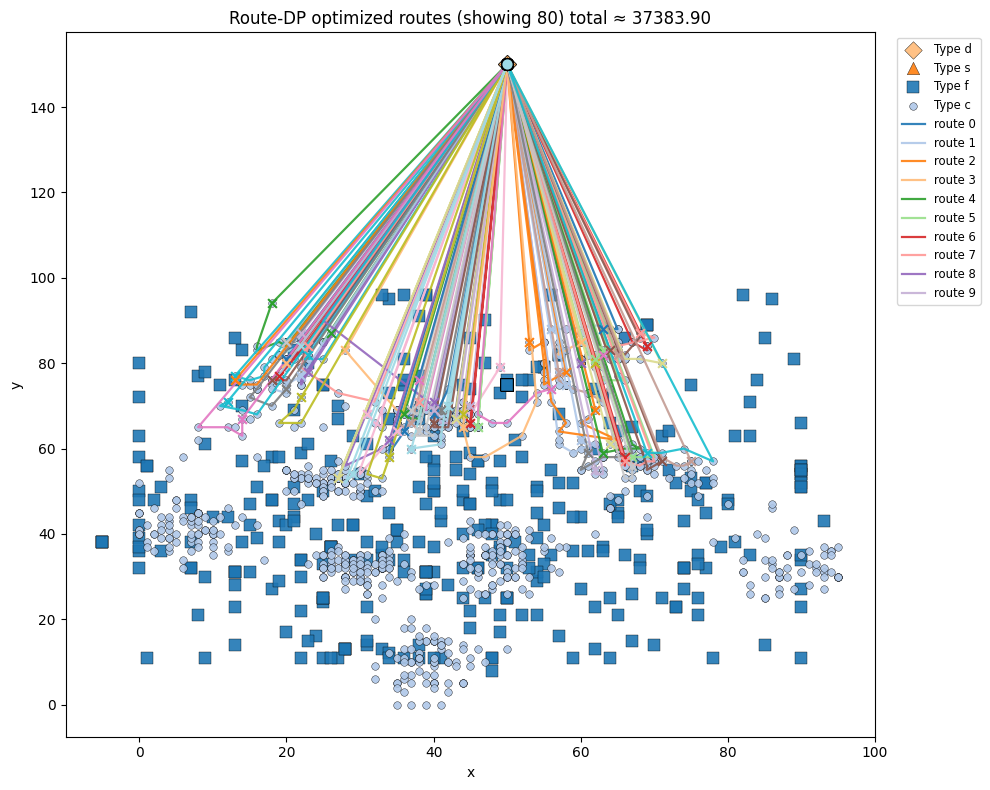

Route 0: customers=[827, 279, 828, 420], load=78.0, cost=129.14
Route 1: customers=[1908, 1448, 534], load=79.0, cost=131.76
Route 2: customers=[1609, 859, 170, 12], load=93.0, cost=135.09
Route 3: customers=[1463, 148, 760, 488, 1924, 1995], load=99.0, cost=138.38
Route 4: customers=[1564, 1303, 96, 1325], load=78.0, cost=139.29
Route 5: customers=[873, 1992, 399, 580, 1348], load=97.0, cost=139.55
Route 6: customers=[1837, 418, 482, 537, 126], load=92.0, cost=139.70
Route 7: customers=[1380, 1677, 1651, 168], load=90.0, cost=140.85
Route 8: customers=[169, 59, 16, 78, 1840, 253, 207, 1423], load=100.0, cost=141.43
Route 9: customers=[1648, 1836, 162, 32, 1217], load=71.0, cost=141.72


In [15]:
# Route-level Dynamic Programming (Held-Karp) + 2-opt fallback
# Uses existing dataframe: df_2k (must be present in notebook)
# Uses existing plotting utils: plt, np
# Produces optimized routes for each route in `improved_routes` (falls back to `init_routes` or `nn_routes`)

# choose source routes
_src_routes = None
if 'improved_routes' in globals() and improved_routes:
    _src_routes = improved_routes
elif 'init_routes' in globals() and init_routes:
    _src_routes = init_routes
elif 'nn_routes' in globals() and nn_routes:
    _src_routes = nn_routes
else:
    raise RuntimeError("No source routes found (improved_routes / init_routes / nn_routes required)")

data = df_2k  # explicit per user request
if data is None or data.empty:
    raise RuntimeError("df_2k is empty or not available")

# find depot (first Type == 'd')
dep_rows = data[data['Type'] == 'd'].dropna(subset=['x', 'y'])
if dep_rows.empty:
    raise RuntimeError("No depot (Type=='d') found in df_2k")
depot = dep_rows.iloc[0]

def coord(idx):
    """Return (x,y) for a dataframe index or None,None if missing."""
    try:
        r = data.loc[idx]
        return float(r['x']), float(r['y'])
    except Exception:
        return None, None

def euclid(a, b):
    ax, ay = a; bx, by = b
    return np.hypot(ax - bx, ay - by)

def route_customers_from(r):
    """Extract customer indices (integers) from stored route representation."""
    nodes = r.get('route', r) if isinstance(r, dict) else r
    custs = [n for n in nodes if n != '__DEPOT__' and not (isinstance(n, str) and n.startswith('__DEPOT__'))]
    return [int(n) for n in custs]

# Held-Karp implementation (exact TSP on route customers, start/end at depot)
def held_karp(customers):
    m = len(customers)
    if m == 0:
        return []
    # node list: customers[0..m-1]
    points = [coord(c) for c in customers]
    depot_pt = (float(depot['x']), float(depot['y']))
    # precompute distances
    dist0 = [euclid(depot_pt, p) for p in points]  # depot -> i
    dist = [[euclid(p_i, p_j) for p_j in points] for p_i in points]
    # DP arrays: dp[mask][i] = cost to reach i finishing at i with visited=mask
    Nmask = 1 << m
    dp = [ [np.inf]*m for _ in range(Nmask) ]
    parent = [ [ -1 ]*m for _ in range(Nmask) ]
    # init
    for i in range(m):
        dp[1<<i][i] = dist0[i]
    # iterate masks
    for mask in range(1, Nmask):
        for last in range(m):
            if not (mask & (1<<last)):
                continue
            cur_cost = dp[mask][last]
            if cur_cost == np.inf:
                continue
            # try extend
            rem = (~mask) & (Nmask-1)
            j = rem
            while j:
                lsb = j & -j
                nxt = (lsb.bit_length() - 1)
                new_mask = mask | (1<<nxt)
                new_cost = cur_cost + dist[last][nxt]
                if new_cost < dp[new_mask][nxt]:
                    dp[new_mask][nxt] = new_cost
                    parent[new_mask][nxt] = last
                j -= lsb
    # close to depot
    full = Nmask - 1
    best_cost = np.inf
    best_last = -1
    for i in range(m):
        c = dp[full][i] + euclid(points[i], depot_pt)
        if c < best_cost:
            best_cost = c
            best_last = i
    # reconstruct path
    order = []
    mask = full
    cur = best_last
    while cur != -1:
        order.append(customers[cur])
        p = parent[mask][cur]
        mask = mask & ~(1<<cur)
        cur = p
    order.reverse()
    return order

# simple 2-opt for fallback/large routes
def two_opt_route(customers, max_iter=200):
    if len(customers) < 3:
        return customers[:]
    pts = [coord(c) for c in customers]
    def total_cost(seq):
        cost = euclid((depot['x'], depot['y']), coord(seq[0])) if seq else 0.0
        for a,b in zip(seq[:-1], seq[1:]):
            cost += euclid(coord(a), coord(b))
        if seq:
            cost += euclid(coord(seq[-1]), (depot['x'], depot['y']))
        return cost
    best = customers[:]
    best_cost = total_cost(best)
    improved = True
    it = 0
    while improved and it < max_iter:
        improved = False
        it += 1
        n = len(best)
        for i in range(0, n-2):
            for j in range(i+1, n):
                if j - i == 1:
                    continue
                new = best[:i+1] + list(reversed(best[i+1:j+1])) + best[j+1:]
                nc = total_cost(new)
                if nc + 1e-8 < best_cost:
                    best = new
                    best_cost = nc
                    improved = True
                    break
            if improved:
                break
    return best

# optimize each route (Held-Karp when small, else 2-opt)
optimized_routes = []
orig_total = 0.0
for r in _src_routes:
    custs = route_customers_from(r)
    # compute original cost
    # cost function
    cost = 0.0
    cur = (depot['x'], depot['y'])
    for c in custs:
        pt = coord(c)
        if pt[0] is None:
            continue
        cost += euclid(cur, pt)
        cur = pt
    cost += euclid(cur, (depot['x'], depot['y']))
    orig_total += cost

    if len(custs) <= 12:
        opt = held_karp(custs)
    else:
        opt = two_opt_route(custs)

    # compute optimized cost
    opt_cost = 0.0
    cur = (depot['x'], depot['y'])
    for c in opt:
        pt = coord(c)
        if pt[0] is None:
            continue
        opt_cost += euclid(cur, pt)
        cur = pt
    opt_cost += euclid(cur, (depot['x'], depot['y']))

    optimized_routes.append({'route': ['__DEPOT__'] + opt + ['__DEPOT__'], 'cost': float(opt_cost), 'load': float(sum(float(data.loc[int(c),'demand']) if (int(c) in data.index and not np.isnan(data.loc[int(c),'demand'])) else 0.0 for c in opt))})

new_total = sum(r['cost'] for r in optimized_routes)

print(f"Route-DP: routes optimized={len(optimized_routes)}, total before ≈ {orig_total:.2f}, total after ≈ {new_total:.2f}")

# Visualize first up to max_routes (reuse plotting style)
max_routes = 80
routes_to_plot = optimized_routes if max_routes is None else optimized_routes[:max_routes]

plt.figure(figsize=(10,8))
markers = {'d': 'D', 'f': 's', 's': '^', 'c': 'o'}
types_present = data['Type'].unique()
colmap = color_map if 'color_map' in globals() else {}
for t in types_present:
    sub = data[data['Type'] == t].dropna(subset=['x','y'])
    if sub.empty: 
        continue
    col = colmap.get(t, (0.5,0.5,0.5,0.9))
    m = markers.get(t, 'o')
    plt.scatter(sub['x'], sub['y'], c=[col], label=f"Type {t}", s=30 if t=='c' else 80, marker=m, edgecolor='k', linewidth=0.3, alpha=0.9)

route_cmap = plt.get_cmap('tab20')
route_colors = [route_cmap(i % 20) for i in range(len(routes_to_plot))]

for i, rr in enumerate(routes_to_plot):
    nodes = rr['route']
    xs, ys = [], []
    for n in nodes:
        if n == '__DEPOT__':
            x,y = float(depot['x']), float(depot['y'])
        else:
            x,y = coord(int(n))
        if x is None or np.isnan(x):
            continue
        xs.append(x); ys.append(y)
    if len(xs) < 2:
        continue
    plt.plot(xs, ys, color=route_colors[i], linewidth=1.6, alpha=0.9, label=f"route {i}" if i<10 else None)
    plt.scatter(xs[0], ys[0], c=[route_colors[i]], edgecolor='k', s=70, zorder=5)
    if len(xs)>1:
        plt.scatter(xs[1], ys[1], c=[route_colors[i]], marker='x', s=40, zorder=5)

plt.title(f"Route-DP optimized routes (showing {len(routes_to_plot)}) total ≈ {new_total:.2f}")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc='upper left', bbox_to_anchor=(1.02,1), ncol=1, fontsize='small')
plt.tight_layout()
plt.show()

# textual summary
for i, r in enumerate(optimized_routes[:10]):
    print(f"Route {i}: customers={r['route'][1:-1]}, load={r['load']:.1f}, cost={r['cost']:.2f}")

## Route Genetic Algorithm - Sameh Rebhi

Genetic Algorithm: 179 routes, total cost ≈ 38466.97


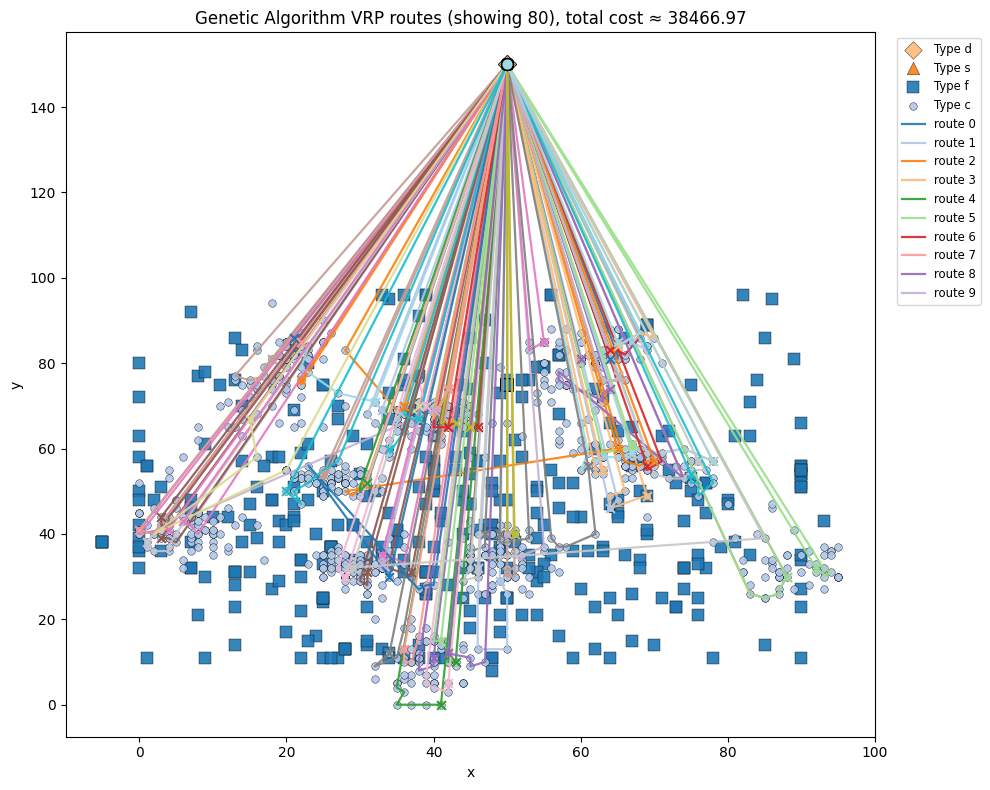

Route 0: customers=[991, 1282], load=71.0, cost=143.27
Route 1: customers=[1310, 1156, 1289, 1744], load=95.0, cost=210.27
Route 2: customers=[145, 440, 1563, 507], load=98.0, cost=234.30
Route 3: customers=[323, 579, 533, 1057], load=96.0, cost=200.25
Route 4: customers=[1794, 1422, 759, 1371, 742, 1540], load=96.0, cost=307.61
Route 5: customers=[528, 1377, 511, 1701, 1953, 651], load=93.0, cost=256.67
Route 6: customers=[1585, 275, 349], load=97.0, cost=170.19
Route 7: customers=[483, 1440, 1766, 1066, 1610, 1334], load=98.0, cost=282.33
Route 8: customers=[1423, 207, 253, 1840, 78, 16, 59, 169], load=100.0, cost=141.43
Route 9: customers=[118, 1261, 74, 1151, 1769], load=113.0, cost=234.70


In [16]:
import random

# Route-level Genetic Algorithm for VRP (uses df_2k, improved_routes, depot info)
# Each individual is a list of customer sequences (routes), depot endpoints are added for cost calculation

# Helper functions
def get_depot(df):
    depots = df[df['Type'] == 'd'].dropna(subset=['x', 'y'])
    if depots.empty:
        raise ValueError("No depot found in dataframe")
    return depots.iloc[0]

def coord(idx):
    try:
        r = df_2k.loc[idx]
        return float(r['x']), float(r['y'])
    except Exception:
        return None, None

def euclid(a, b):
    ax, ay = a; bx, by = b
    return ((ax - bx)**2 + (ay - by)**2)**0.5

def route_cost(route_customers, depot):
    nodes = ['__DEPOT__'] + list(route_customers) + ['__DEPOT__']
    cost = 0.0
    for u, v in zip(nodes[:-1], nodes[1:]):
        x1, y1 = (depot['x'], depot['y']) if u == '__DEPOT__' else coord(u)
        x2, y2 = (depot['x'], depot['y']) if v == '__DEPOT__' else coord(v)
        if x1 is None or x2 is None:
            continue
        cost += euclid((x1, y1), (x2, y2))
    return cost

def route_load(route_customers):
    return sum(df_2k.loc[n, 'demand'] if n in df_2k.index and not pd.isna(df_2k.loc[n, 'demand']) else 0.0 for n in route_customers)

def flatten_routes(routes):
    # Extract customer indices from route dicts
    return [ [n for n in r['route'] if n != '__DEPOT__' and not (isinstance(n, str) and n.startswith('__DEPOT__'))] for r in routes ]

# Genetic Algorithm parameters
POP_SIZE = 30
NGEN = 80
MUT_RATE = 0.25
CROSS_RATE = 0.7
capacity = 100

depot = get_depot(df_2k)
init_pop = [flatten_routes(improved_routes)[i % len(improved_routes)] for i in range(POP_SIZE)]

def fitness(ind):
    # ind: list of routes (list of customer indices)
    total = 0.0
    for r in ind:
        if route_load(r) > capacity:
            return 1e6  # penalize infeasible
        total += route_cost(r, depot)
    return total

def crossover(parent1, parent2):
    # Route-level crossover: swap random routes between parents
    child1 = [r[:] for r in parent1]
    child2 = [r[:] for r in parent2]
    if len(child1) > 1 and len(child2) > 1:
        idx1 = random.randint(0, len(child1)-1)
        idx2 = random.randint(0, len(child2)-1)
        child1[idx1], child2[idx2] = child2[idx2], child1[idx1]
    return child1, child2

def mutate(ind):
    # Randomly relocate a customer between routes
    ind = [r[:] for r in ind]
    if len(ind) < 2:
        return ind
    src = random.randint(0, len(ind)-1)
    dst = random.randint(0, len(ind)-1)
    if src != dst and ind[src]:
        cust_idx = random.randint(0, len(ind[src])-1)
        cust = ind[src].pop(cust_idx)
        insert_pos = random.randint(0, len(ind[dst]))
        ind[dst].insert(insert_pos, cust)
    return ind

# Initialize population
population = [flatten_routes(improved_routes)[i % len(improved_routes)] for i in range(POP_SIZE)]

# Each individual is a list of routes (list of customer indices)
population = [random.sample(flatten_routes(improved_routes), k=len(flatten_routes(improved_routes))) for _ in range(POP_SIZE)]

for gen in range(NGEN):
    # Evaluate fitness
    scores = [fitness(ind) for ind in population]
    # Select best individuals
    sorted_pop = [x for _, x in sorted(zip(scores, population), key=lambda pair: pair[0])]
    population = sorted_pop[:POP_SIZE]
    # Generate offspring
    offspring = []
    while len(offspring) < POP_SIZE:
        if random.random() < CROSS_RATE:
            p1, p2 = random.sample(population, 2)
            c1, c2 = crossover(p1, p2)
            offspring.extend([c1, c2])
        else:
            ind = random.choice(population)
            offspring.append(ind)
    # Mutate
    for i in range(len(offspring)):
        if random.random() < MUT_RATE:
            offspring[i] = mutate(offspring[i])
    population = offspring[:POP_SIZE]

# Get best solution
best_ind = min(population, key=fitness)
best_cost = fitness(best_ind)

# Pack results in route dicts
ga_routes = []
for r in best_ind:
    ga_routes.append({
        'route': ['__DEPOT__'] + r + ['__DEPOT__'],
        'cost': route_cost(r, depot),
        'load': route_load(r)
    })
ga_total_cost = sum(r['cost'] for r in ga_routes)

print(f"Genetic Algorithm: {len(ga_routes)} routes, total cost ≈ {ga_total_cost:.2f}")

# Visualization (reuse plotting style)
max_routes = 80
routes_to_plot = ga_routes if max_routes is None else ga_routes[:max_routes]

plt.figure(figsize=(10, 8))
types_present = df_2k['Type'].unique()
markers = {'d': 'D', 'f': 's', 's': '^', 'c': 'o'}
for t in types_present:
    sub = df_2k[df_2k['Type'] == t].dropna(subset=['x', 'y'])
    if sub.empty:
        continue
    col = color_map.get(t, (0.5, 0.5, 0.5, 0.9)) if 'color_map' in globals() else (0.5, 0.5, 0.5, 0.9)
    m = markers.get(t, 'o')
    plt.scatter(sub['x'], sub['y'], c=[col], label=f"Type {t}", s=30 if t == 'c' else 80, marker=m, edgecolor='k', linewidth=0.3, alpha=0.9)

route_cmap = plt.get_cmap('tab20')
route_colors = [route_cmap(i % 20) for i in range(len(routes_to_plot))]

def _coord_ga(idx):
    if idx == '__DEPOT__':
        return float(depot['x']), float(depot['y'])
    try:
        r = df_2k.loc[idx]
        return float(r['x']), float(r['y'])
    except Exception:
        return None, None

for i, r in enumerate(routes_to_plot):
    nodes = r['route']
    xs, ys = [], []
    for n in nodes:
        x, y = _coord_ga(n)
        if x is None or y is None or np.isnan(x) or np.isnan(y):
            continue
        xs.append(x); ys.append(y)
    if len(xs) < 2:
        continue
    plt.plot(xs, ys, color=route_colors[i], linewidth=1.6, alpha=0.9, label=f"route {i}" if i < 10 else None)
    plt.scatter(xs[0], ys[0], c=[route_colors[i]], edgecolor='k', s=70, zorder=5)
    if len(xs) > 1:
        plt.scatter(xs[1], ys[1], c=[route_colors[i]], marker='x', s=40, zorder=5)

plt.title(f"Genetic Algorithm VRP routes (showing {len(routes_to_plot)}), total cost ≈ {ga_total_cost:.2f}")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.show()

# Compact textual summary
for i, r in enumerate(ga_routes[:10]):
    print(f"Route {i}: customers={r['route'][1:-1]}, load={r['load']:.1f}, cost={r['cost']:.2f}")

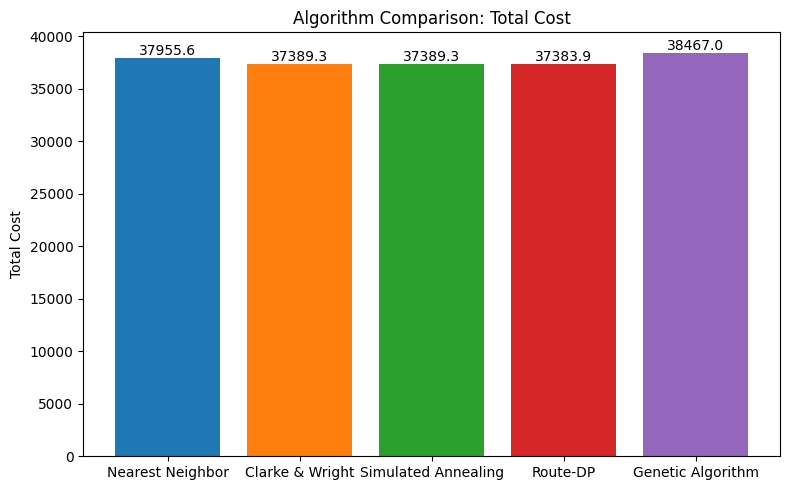

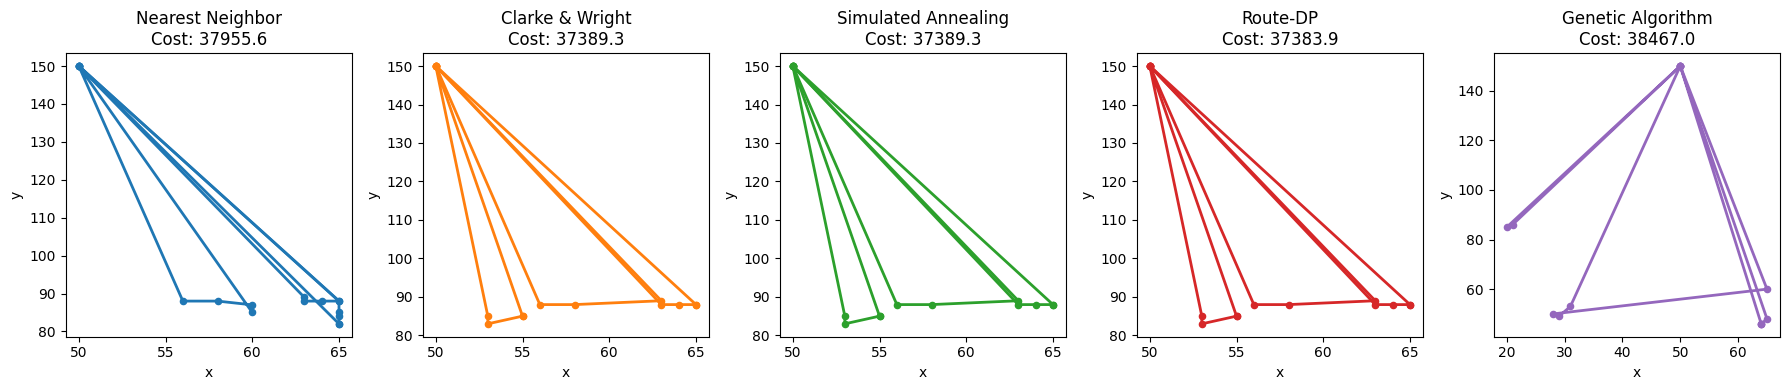

Nearest Neighbor: 177 routes, total cost = 37955.60
Clarke & Wright: 179 routes, total cost = 37389.34
Simulated Annealing: 179 routes, total cost = 37389.34
Route-DP: 179 routes, total cost = 37383.90
Genetic Algorithm: 179 routes, total cost = 38466.97

Best algorithm: Route-DP (total cost = 37383.90)


In [17]:
# Compare the 6 algorithms: Nearest Neighbor, Clarke & Wright, Simulated Annealing, Route-DP, Genetic Algorithm, and the initial solution
# Uses: nn_routes, cw_routes, improved_routes, optimized_routes, ga_routes, nn_total_cost, cw_total_cost, improved_total_cost, new_total, ga_total_cost
# Uses: df_2k, color_map, route_cmap, route_colors, plt, depot

import matplotlib.pyplot as plt

algos = [
    {
        'name': 'Nearest Neighbor',
        'routes': nn_routes,
        'total_cost': float(nn_total_cost),
        'color': 'tab:blue'
    },
    {
        'name': 'Clarke & Wright',
        'routes': cw_routes,
        'total_cost': float(cw_total_cost),
        'color': 'tab:orange'
    },
    {
        'name': 'Simulated Annealing',
        'routes': improved_routes,
        'total_cost': float(improved_total_cost),
        'color': 'tab:green'
    },
    {
        'name': 'Route-DP',
        'routes': optimized_routes,
        'total_cost': float(new_total),
        'color': 'tab:red'
    },
    {
        'name': 'Genetic Algorithm',
        'routes': ga_routes,
        'total_cost': float(ga_total_cost),
        'color': 'tab:purple'
    }
]

# Visual comparison: bar chart of total costs
plt.figure(figsize=(8,5))
names = [a['name'] for a in algos]
costs = [a['total_cost'] for a in algos]
bars = plt.bar(names, costs, color=[a['color'] for a in algos])
plt.ylabel('Total Cost')
plt.title('Algorithm Comparison: Total Cost')
for bar, cost in zip(bars, costs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{cost:.1f}", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# Visualize routes for each algorithm (first 3 routes for clarity)
fig, axs = plt.subplots(1, len(algos), figsize=(18,4))
for idx, algo in enumerate(algos):
    ax = axs[idx]
    routes = algo['routes'][:3]
    route_colors = [algo['color']] * len(routes)
    for i, r in enumerate(routes):
        nodes = r['route']
        xs, ys = [], []
        for n in nodes:
            if n == '__DEPOT__':
                x, y = float(depot['x']), float(depot['y'])
            else:
                try:
                    x, y = float(df_2k.loc[n, 'x']), float(df_2k.loc[n, 'y'])
                except Exception:
                    x, y = None, None
            if x is None or y is None or (hasattr(x, 'isnan') and x.isnan()):
                continue
            xs.append(x)
            ys.append(y)
        if len(xs) > 1:
            ax.plot(xs, ys, color=route_colors[i], linewidth=2)
            ax.scatter(xs, ys, color=route_colors[i], s=20)
    ax.set_title(f"{algo['name']}\nCost: {algo['total_cost']:.1f}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.tight_layout()
plt.show()

# Print summary and best algorithm
for a in algos:
    print(f"{a['name']}: {len(a['routes'])} routes, total cost = {a['total_cost']:.2f}")

best_algo = min(algos, key=lambda a: a['total_cost'])
print(f"\nBest algorithm: {best_algo['name']} (total cost = {best_algo['total_cost']:.2f})")